In [1]:
# import libaries

import numpy as np
import torch
import random
import torch.nn as nn
import sys
import pandas as pd
from PIL import Image

from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

In [4]:
import shutil

shutil.rmtree("E:\\JupyterNotebooks\\7zE815C1DCF\\vggface2_224")

In [3]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Sun Jan 29 16:00:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P2    55W / 175W |    317Mi

In [4]:
seed = 41
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, training_csv = None, training_dir = None, transform = None):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create contructors
        self.unique_img_name = None
        self.data = dict()
        self.image = list()
        self.identities = list()
        # read csv file
        self.train_df = pd.read_csv(training_csv)
        #get the length of entire dataset
        self.len_train = len(self.train_df)
        # set the transformation
        self.transform = transform
        # set the train directory
        self.train_dir = training_dir
        # group each identity together and create list of each identity imgs
        self.train_df = self.train_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis = 1)
        # load imgs
        self.load_imgs(self.train_df)

    def __len__(self):
        return len(self.image)

    # get each pair of images -> 1: same identity, 0: different identity 
    # if index is even -> same pair 
    # if index is odd -> random identity
    def __getitem__(self, idx):
        img1 = None 
        img2 = None
        label = None
        if idx % 2 == 0:
            # random pick the identity
            random_identity = np.random.choice(self.unique_img_name, size = 1)[0]
            random_img = random.sample(self.data[random_identity], 2)
            img1 = random_img[0]
            img2 = random_img[1]
            label = 1
        else:
            random_identity = np.random.choice(self.unique_img_name, size = 2)
            img1 = random.choice(self.data[random_identity[0]])
            img2 = random.choice(self.data[random_identity[1]])
            label = 0
#         return self.train_df
        return img1, img2, torch.from_numpy(np.array([label], dtype = np.float64))

    def load_imgs(self, df):
        # iterate thought each row
        for _, row in df.iterrows():
            # get identity of each row
            row_identities = row['identity']
            # check if not identity is in self.data
            if row_identities not in self.data:
                # create key in self.data as new identity
                self.data[row_identities] = list()
            # loop imgs in each identity
            for img_name in row['filenames']:
                # concatenate the directoru and image name
                path_to_image = self.train_dir+img_name
                # open image and convert to RGB
                img = Image.open(path_to_image).convert('RGB')
                # check img transformations
                if self.transform == None:
                    # self.transform is not define, convert the img to tensor
                    convert_tensor = transforms.ToTensor()
                    img = convert_tensor(img)
                else:
                    # transforms img
                    img = self.transform(img)
                    
                self.data[row_identities].append(img)
                self.image.append(img)
                self.identities.append(img_name)
                
        self.unique_img_name = np.array(list(self.data.keys()))

    def rotate_imgs(self, path_to_img):
        img = Image.open(path_to_img).convert('RGB')
        is_rotate = random.choice([True,False])
        angle_rotation = [90,180,270,360]
        if is_rotate:
            degree = random.choice(angle_rotation)
            img = img.rotate(degree)
        return img


# Preperation of dataset

In [5]:
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_batch_size = 32
val_batch_size = 32

train_siamese_dataset = FaceDataset(training_csv = "./large_prepared_data/train/label_df.csv", training_dir="./large_prepared_data/train/", transform = train_transform)
train_siamese_dataloader = DataLoader(train_siamese_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)

val_siamese_dataset = FaceDataset(training_csv = "./large_prepared_data/val/label_df.csv", training_dir="./large_prepared_data/val/", transform = val_transform)
val_siamese_dataloader = DataLoader(val_siamese_dataset, batch_size=val_batch_size, shuffle=True, pin_memory=True)

In [7]:
val_siamese_dataset.__len__()

302

# Siamese Network

In [8]:
from torchvision.models import resnet18,resnet50

resnet18 = resnet18().children()
resnet18 = list(resnet18)[:-1]

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            *(resnet18),
            nn.Flatten(),
#             nn.Linear(2048, 512),
            # nn.ReLU(),
            # nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.PReLU()
        )
    def forward_once(self, input):
        output = self.layers(input)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [11]:
siamese_model = SiameseNetwork()

In [12]:
summary(siamese_model)

Layer (type:depth-idx)                        Param #
SiameseNetwork                                --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

In [13]:
print(summary(siamese_model, input_size=[(32,3,224,224),(32,3,224,224)]))

Layer (type:depth-idx)                        Output Shape              Param #
SiameseNetwork                                [32, 128]                 --
├─Sequential: 1-1                             [32, 128]                 --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         295,42

In [14]:
class ContrastiveLoss(torch.nn.Module):
    # TODO 6: implement the contrastive loss
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2).view((-1, 1))
        loss_contrastive = torch.mean((distance * label) + (torch.relu(self.margin - distance) * ((label + 1) % 2)))
        return loss_contrastive

In [15]:
siamese_margin = 1.2
siamese_criterion = ContrastiveLoss(margin=siamese_margin)

In [19]:
siamese_optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)
siamese_scheduler = optim.lr_scheduler.ReduceLROnPlateau(siamese_optimizer, 'min', patience=2, factor=0.01, min_lr=1e-8, threshold=1e-1, verbose=True)

In [20]:
def train_with_val(load_weight_path = None, save_weight_path = None, load_weight = False, num_epochs = 200):
    # throw model to compute in the device
    siamese_model.to(device=device)
    total_train_loss = list()
    total_val_loss = list()
    best_val_loss = 0
    best_train_loss = 0
    previous_lr = 0

    # load weight
    if bool(load_weight_path) & load_weight:
        siamese_model.load_state_dict(torch.load(load_weight_path))
        print('Congratulations, Weight has been loaded!')

    # iterate though each epoch
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch:{epoch+1}/{num_epochs}')
        # set model to train mode
        siamese_model.train()
        epoch_train_loss = list()
        train_loss = 0

        # switch to train mode
        siamese_model.train()
        with torch.set_grad_enabled(True): 
            # loop though each item in dataloader
            for img1, img2, label in tqdm(train_siamese_dataloader):
                # throw img to compute in the device
                img1 = img1.to(device)
                img2 = img2.to(device)
                label = label.to(device)
                # clear gradient to prevent gradient vanish
                siamese_optimizer.zero_grad()
                # train model
                output1, output2 = siamese_model(img1, img2)
                # compute loss from criterion
                loss = siamese_criterion(output1, output2, label)
                # backward propagate
                loss.backward()
                # update parameters
                siamese_optimizer.step()
                # append train loss to epoch_train_loss
                train_loss += loss.item() * img1.size(0)

        # calculate loss
        current_train_loss = train_loss / len(train_siamese_dataloader.sampler)
        total_train_loss.append(current_train_loss)

        # switch mode to eval
        siamese_model.eval()
        with torch.no_grad():
            val_loss = 0
            for img1, img2, label in val_siamese_dataloader:
                # throw img to compute in the device
                img1 = img1.to(device)
                img2 = img2.to(device)
                label = label.to(device)
                # clear gradient to prevent gradient vanish
                siamese_optimizer.zero_grad()
                # compute the out in eval mode
                output1, output2 = siamese_model(img1, img2)
                # compute loss in eval mode
                loss = siamese_criterion(output1, output2, label)
                # calculate loss for each feature
                val_loss += loss.item()* img1.size(0)
                # calculate loss for each batch
        current_val_loss = val_loss / len(val_siamese_dataloader.sampler)
        # get learning rate from model
        optim_lr = siamese_optimizer.param_groups[0]['lr']
        # append current validation loss to list
        total_val_loss.append(current_val_loss)
        if (best_val_loss == 0) | (best_train_loss == 0):
            best_val_loss = current_val_loss
            best_train_loss = current_train_loss
        # find the best val loss
        if best_val_loss >= current_val_loss:
            best_val_loss = current_val_loss
        # find the best train loss
        if best_train_loss >= current_train_loss:
            best_train_loss = current_train_loss

        print(f'train loss: {current_train_loss}')
        print(f'val loss: {current_val_loss}')
        print(f'Learning rate: {optim_lr:.8f}')
        if (optim_lr < previous_lr) | (optim_lr > previous_lr):
            print('LEARNING RATE HAS CHANGED!')
        print('-------------------------------------------------------------')
        # replace the previous lr with the current lr
        previous_lr = optim_lr
    print('Best Validation loss',best_val_loss)
    print('Best Train loss', best_train_loss)

    # save model weights
    torch.save(siamese_model.state_dict(), save_weight_path)
    # plot loss
    plt.plot(np.arange(1,len(total_train_loss)+1), total_train_loss,label = 'Train Loss')
    plt.plot(np.arange(1,len(total_val_loss)+1),total_val_loss, label= 'Validation loss')
    plt.legend()
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.501062879517093
val loss: 0.48618588201849666
Learning rate: 0.00010000
LEARNING RATE HAS CHANGED!
-------------------------------------------------------------
Epoch:2/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.49232914037773007
val loss: 0.4957790309439925
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:3/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4716623189023388
val loss: 0.5112406687397781
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:4/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.49539186624653286
val loss: 0.47192040202670443
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:5/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.5085984837347967
val loss: 0.5227441892046358
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:6/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.48576687680867175
val loss: 0.47565419601880954
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:7/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.48849502967429603
val loss: 0.5098746479920648
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:8/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4961882383732825
val loss: 0.46878809952454653
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:9/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.48297029687761034
val loss: 0.45050097814921464
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:10/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.47661759318818303
val loss: 0.4541088952359108
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:11/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.47657828767013255
val loss: 0.44245886217050306
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:12/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.46345837194877976
val loss: 0.4414653313586747
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:13/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4617271856513846
val loss: 0.4618255486187605
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:14/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4675156828375568
val loss: 0.4674880267398444
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:15/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4662519351351677
val loss: 0.4505063676929089
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:16/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.44752503736919935
val loss: 0.49241371090456054
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:17/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.46389676557674053
val loss: 0.4459625835814174
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:18/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.46304442955054786
val loss: 0.48673490761618887
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:19/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4838363443434361
val loss: 0.4835678635701685
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:20/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4571353252357526
val loss: 0.48671109001583956
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:21/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.45152418068791805
val loss: 0.5093218899803816
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:22/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.45122962971609964
val loss: 0.4522550088516899
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:23/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.43590483875979635
val loss: 0.4433017222107456
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:24/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4366618945215517
val loss: 0.46762125754254
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:25/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4465740333225203
val loss: 0.42935707464518136
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:26/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4389699331605214
val loss: 0.4514375036761214
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:27/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.43957096815904795
val loss: 0.45992702833031435
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:28/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.41133766039685793
val loss: 0.43839752466097126
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:29/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4312567624850562
val loss: 0.4379531493354959
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:30/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.41012888648671536
val loss: 0.4413441386758442
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:31/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.41151985564332233
val loss: 0.431110114978614
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:32/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.42095361127072534
val loss: 0.45915901896371103
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:33/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.43917368406112434
val loss: 0.4737058136525829
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:34/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.42078116546390726
val loss: 0.46663594838472344
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:35/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.417323113563308
val loss: 0.4457459535576181
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:36/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4232157282653653
val loss: 0.4629709027315928
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:37/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.41599047864793015
val loss: 0.4243829242734004
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:38/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.43109313944159594
val loss: 0.4614941139693144
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:39/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4252045079010101
val loss: 0.4642218752542128
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:40/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4195617864784274
val loss: 0.4541269908720837
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:41/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.42587257156137076
val loss: 0.42527808470571327
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:42/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.41183212674098585
val loss: 0.45754332868505687
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:43/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4377740927729029
val loss: 0.44983233078089946
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:44/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4180730508215863
val loss: 0.4591747494676576
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:45/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4080757515753564
val loss: 0.4293687005661465
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:46/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4185511591345133
val loss: 0.46843722758086903
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:47/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.4100565922853883
val loss: 0.4398543430594049
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:48/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.401253547152271
val loss: 0.47583614193698676
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:49/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3874739230734734
val loss: 0.43456881988981727
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:50/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.39587865800461
val loss: 0.46173118301189275
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:51/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37572743135066494
val loss: 0.4821912057324627
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:52/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.389426590518326
val loss: 0.4263773867856582
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:53/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.39577186213963084
val loss: 0.4547360961044836
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:54/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.38623009493050514
val loss: 0.43030551403054706
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:55/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3940852518857015
val loss: 0.45035802222177734
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:56/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3821821444883973
val loss: 0.42706355037836863
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:57/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3922283189290909
val loss: 0.42497510663295374
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:58/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.38966669050452646
val loss: 0.46187792670957756
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:59/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3888874436810888
val loss: 0.4450433542273495
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:60/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.39598023346500966
val loss: 0.4322108748613314
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:61/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3810188525495955
val loss: 0.4601635156825358
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:62/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.38708493771448393
val loss: 0.4570643896582407
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:63/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.387602642457741
val loss: 0.48041919384164034
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:64/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.376045254151312
val loss: 0.48564745986291413
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:65/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37966113728174683
val loss: 0.4735834167253331
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:66/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37000482513261407
val loss: 0.43627751502748086
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:67/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3718272634233048
val loss: 0.41849233140777303
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:68/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36637363653913047
val loss: 0.40189588966814876
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:69/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36661014723413654
val loss: 0.45073436725605587
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:70/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3700870030240234
val loss: 0.4632566428887087
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:71/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37345894069871743
val loss: 0.4731832655942351
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:72/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.38423654074021435
val loss: 0.4297868298911736
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:73/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37835111028076873
val loss: 0.452931392192378
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:74/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37719276986128863
val loss: 0.4243352980424638
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:75/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.365458891064204
val loss: 0.42160770168376854
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:76/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37835645052151146
val loss: 0.4737121254712226
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:77/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36071813856031615
val loss: 0.45554594769503376
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:78/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34150287253281114
val loss: 0.5056748029680318
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:79/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37549672149947905
val loss: 0.46850922927977395
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:80/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3944687055611268
val loss: 0.4716967923484977
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:81/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36689644081430084
val loss: 0.4333499444861409
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:82/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.38119461788610387
val loss: 0.4112282103800295
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:83/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3611830798844048
val loss: 0.4078136043906804
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:84/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.381851085901138
val loss: 0.4477004993977549
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:85/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36176965696320273
val loss: 0.4578455123149895
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:86/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37721611498424773
val loss: 0.42063502155302945
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:87/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36685175571430023
val loss: 0.5230860983126409
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:88/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.354365414585268
val loss: 0.4164735969704952
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:89/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3805245046983846
val loss: 0.49002147203817076
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:90/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3633073546611981
val loss: 0.47007014352399606
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:91/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3766571875497148
val loss: 0.442687305053989
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:92/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3730504807413726
val loss: 0.4387340663858251
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:93/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35663066040877506
val loss: 0.46750674898495637
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:94/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34841656466444965
val loss: 0.40287908374768255
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:95/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3469196677521575
val loss: 0.4433478487490535
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:96/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36075612405387714
val loss: 0.47923937791554466
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:97/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36454316630760625
val loss: 0.4588103540309563
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:98/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35747583818218426
val loss: 0.4757008914117214
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:99/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36174948390848644
val loss: 0.4614407445526904
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:100/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37336817749907897
val loss: 0.4551006374519861
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:101/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.352493831755123
val loss: 0.4888041603847504
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:102/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3596290533513106
val loss: 0.44070606236770093
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:103/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3501026284924921
val loss: 0.38863485361702294
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:104/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33896771356295147
val loss: 0.43956709078984146
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:105/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37309566825873064
val loss: 0.4542423241898195
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:106/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3560910789280732
val loss: 0.4062023145290838
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:107/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36056770201374677
val loss: 0.45342871312565475
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:108/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3459177117435227
val loss: 0.464195948372447
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:109/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35816410905557244
val loss: 0.48775425274426193
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:110/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35766897942886156
val loss: 0.389859037930593
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:111/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3505089267329131
val loss: 0.45062706042002093
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:112/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3482347750236917
val loss: 0.44963582893212894
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:113/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33583292625882727
val loss: 0.424149532361027
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:114/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32363367119739006
val loss: 0.44154489633871247
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:115/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3334918174196562
val loss: 0.4144496699212665
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:116/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34332282400978786
val loss: 0.442682505846995
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:117/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33461252950281056
val loss: 0.47789955710597487
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:118/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32424667185111244
val loss: 0.4931840780487944
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:119/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36212878804099297
val loss: 0.44494082164326765
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:120/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35179756526668887
val loss: 0.4270451162837288
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:121/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3194966800180044
val loss: 0.5024762273589165
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:122/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3549579535601412
val loss: 0.4390817591317217
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:123/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3389782365981405
val loss: 0.45602262820427875
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:124/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34964311700429024
val loss: 0.4162686181176432
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:125/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3320058976963652
val loss: 0.4343948856509593
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:126/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3255154405229054
val loss: 0.42747575167263163
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:127/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.333944036299554
val loss: 0.44815270866757717
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:128/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35380271212848047
val loss: 0.4237159068600987
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:129/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3755421836697927
val loss: 0.4526861468725144
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:130/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3335189698697154
val loss: 0.441004419215966
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:131/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.338853841525688
val loss: 0.40436294956746843
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:132/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3432882323912756
val loss: 0.43922232997375127
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:133/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36387466074960034
val loss: 0.512203889253082
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:134/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.39489689387889765
val loss: 0.3917021072248578
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:135/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.37615869335516583
val loss: 0.40945664102875395
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:136/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3599614484478515
val loss: 0.44293137480846345
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:137/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3705006774885913
val loss: 0.46112286254336876
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:138/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36518300662488434
val loss: 0.4825026498969092
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:139/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32364547317532066
val loss: 0.4541728956939418
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:140/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3701137996904047
val loss: 0.4639244444630901
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:141/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3563065138692323
val loss: 0.4387226251925578
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:142/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36392672640449336
val loss: 0.397861557698979
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:143/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34003544128815466
val loss: 0.5192679617453628
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:144/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3474093553736362
val loss: 0.4358480612310621
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:145/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.341083946688487
val loss: 0.4211152291253235
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:146/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3392590748715105
val loss: 0.384868472613917
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:147/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35367418324614985
val loss: 0.4293926022695308
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:148/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33520663052804966
val loss: 0.4955689865819295
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:149/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3574192346042133
val loss: 0.36358341368581
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:150/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33683895422633375
val loss: 0.48052967929810175
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:151/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3553963846413254
val loss: 0.40600734396871574
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:152/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33009655166396323
val loss: 0.4121074435130887
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:153/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3398333360347801
val loss: 0.42135663009022684
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:154/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34120686353634644
val loss: 0.3651691942104903
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:155/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33059628509416283
val loss: 0.47040834664650466
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:156/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.299927478161061
val loss: 0.43253987568132046
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:157/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32866029236107125
val loss: 0.4729269734686526
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:158/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3259393081264054
val loss: 0.44300674511049276
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:159/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.31316220821072666
val loss: 0.46904203252650656
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:160/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3301576692408985
val loss: 0.41291913171697775
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:161/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3255955104045838
val loss: 0.4341593111895772
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:162/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33521883010819314
val loss: 0.4617862414181206
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:163/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3313034240058642
val loss: 0.4456615553127443
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:164/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.325999961620473
val loss: 0.42982427908014836
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:165/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3228090686175697
val loss: 0.4251133835656123
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:166/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3315755442519925
val loss: 0.418023827246525
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:167/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3086061210173385
val loss: 0.3979340530454917
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:168/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.30772167413344403
val loss: 0.48793100254857225
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:169/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33368586965899216
val loss: 0.4675576038408803
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:170/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3110882697299456
val loss: 0.4544697077790321
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:171/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33346775469501183
val loss: 0.4177382921893936
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:172/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3584632552447356
val loss: 0.46287664587445204
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:173/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.36850942062482706
val loss: 0.44839072776122574
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:174/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35404025458814903
val loss: 0.47863437687520005
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:175/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3381799572287988
val loss: 0.39372363880583305
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:176/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34817025324394757
val loss: 0.43367942939041904
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:177/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3677466062346026
val loss: 0.4791561450732457
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:178/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33503412286508577
val loss: 0.4006174587272069
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:179/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32750565517422203
val loss: 0.4453634942857622
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:180/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3303552987729056
val loss: 0.45939936477112037
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:181/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33507709083074677
val loss: 0.48279784468137005
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:182/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3511459727791421
val loss: 0.4019335315059539
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:183/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3613414975332605
val loss: 0.3622235488340248
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:184/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35161619411307643
val loss: 0.42538056588717826
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:185/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3559854932791779
val loss: 0.44508314615876654
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:186/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.35227160054007767
val loss: 0.490124540107773
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:187/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.33714556851652805
val loss: 0.4026212433157387
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:188/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3487145896073291
val loss: 0.4672266389686849
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:189/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3495466080453109
val loss: 0.4487036789101116
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:190/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3410835866881362
val loss: 0.4640867681074745
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:191/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3314016453292148
val loss: 0.44395376212916793
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:192/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3406623762169541
val loss: 0.4457577215160814
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:193/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3170891591300184
val loss: 0.4566924130389007
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:194/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3239163960636167
val loss: 0.45343933999346886
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:195/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3505949200826383
val loss: 0.4982649626333011
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:196/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34319084000372607
val loss: 0.47961739131129216
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:197/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3233750100552584
val loss: 0.4035148997412135
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:198/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.34011729394819096
val loss: 0.4072432903630643
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:199/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.3294749375620859
val loss: 0.42044055578361506
Learning rate: 0.00010000
-------------------------------------------------------------
Epoch:200/200


  0%|          | 0/77 [00:00<?, ?it/s]

train loss: 0.32965963226484873
val loss: 0.4333277323852394
Learning rate: 0.00010000
-------------------------------------------------------------
Best Validation loss 0.3622235488340248
Best Train loss 0.299927478161061


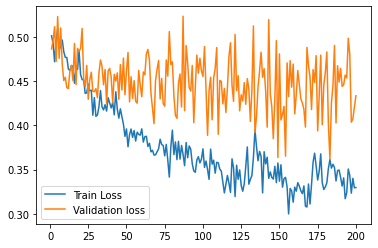

In [21]:
load_weight_path = './weights/siamese_model_resnet18.pth'
save_weight_path = './weights/siamese_model_resnet18_400_x.pth'
load_weight = False
# set epochs rounds
num_epochs = 200
train_with_val(load_weight_path, save_weight_path, load_weight, num_epochs)